In [1]:
import numpy as np

In [2]:
import torch

In [3]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

In [4]:
import data_loaders

In [5]:
from data_loaders import Plain_Dataset, eval_data_dataloader

In [6]:
from deep_emotion import Deep_Emotion

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/youssef/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
print("cuda:0") if torch.cuda.is_available() else print("cpu")

cpu


In [9]:
def calculate_uncertainty(logits):
    probabilities = F.softmax(logits, dim=1)
    uncertainty = -torch.sum(probabilities * torch.log(probabilities), dim=1)
    return uncertainty

In [10]:
def Train(epochs, train_loader, val_loader, criterion, optimizer, device):
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0

        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(data)

            uncertainty = calculate_uncertainty(outputs)

            weights = 1.0 / (1.0 + uncertainty)

            weights = len(labels) * weights / weights.sum()

            loss = criterion(outputs, labels)

            weighted_loss = (loss * weights).mean()

            weighted_loss.backward()
            optimizer.step()
            train_loss += weighted_loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)

            val_uncertainty = calculate_uncertainty(val_outputs)
            val_weights = 1.0 / (1.0 + val_uncertainty)
            val_weights = len(labels) * val_weights / val_weights.sum()

            val_loss = criterion(val_outputs, labels)
            val_weighted_loss = (val_loss * val_weights).mean()

            validation_loss += val_weighted_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        validation_loss = validation_loss / len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)

        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Accuracy {:.3f}% \tValidation Accuracy {:.3f}%'
              .format(e + 1, train_loss, validation_loss, train_acc * 100, val_acc * 100))

    torch.save(net.state_dict(), 'deep_emotion-{}-{}-{}.pt'.format(epochs, batchsize, lr))
    print("===================================Training Finished===================================")

In [11]:
epochs = 2500
lr = 0.001
batchsize = 256

In [12]:
net = Deep_Emotion()

In [13]:
net.to(device)

Deep_Emotion(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (dropout4): Dropout(p=0.25, inplace=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
  (localization): Sequential(
    (0): Conv2d(3, 15, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [14]:
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

In [15]:
traincsv_file = "data2" + "/"+"train.csv"
validationcsv_file = "data2" + "/"+"val.csv"

In [16]:
train_img_dir = "data2"+"/"+"train/"

In [17]:
validation_img_dir = "data2"+"/"+"val/"

In [18]:
train_dataset= Plain_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)


In [19]:
validation_dataset= Plain_Dataset(csv_file=validationcsv_file, img_dir = validation_img_dir, datatype = 'val', transform = transformation)


In [20]:
train_loader= DataLoader(train_dataset,batch_size=batchsize,shuffle = True,num_workers=0)
val_loader=   DataLoader(validation_dataset,batch_size=batchsize,shuffle = True,num_workers=0)

In [21]:
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= 0.00001, weight_decay = 0.0001)

In [22]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================


/home/youssef/.local/lib/python3.8/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/youssef/.local/lib/python3.8/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.00812111 	Validation Loss 0.00873023 	Training Accuracy 14.291% 	Validation Accuracy 31.199%
Epoch: 2 	Training Loss: 0.00804337 	Validation Loss 0.00864552 	Training Accuracy 20.069% 	Validation Accuracy 36.335%
Epoch: 3 	Training Loss: 0.00799947 	Validation Loss 0.00860064 	Training Accuracy 20.261% 	Validation Accuracy 36.194%
Epoch: 4 	Training Loss: 0.00798121 	Validation Loss 0.00856548 	Training Accuracy 20.410% 	Validation Accuracy 35.596%
Epoch: 5 	Training Loss: 0.00797219 	Validation Loss 0.00854010 	Training Accuracy 20.571% 	Validation Accuracy 36.265%
Epoch: 6 	Training Loss: 0.00796291 	Validation Loss 0.00851149 	Training Accuracy 20.871% 	Validation Accuracy 35.420%
Epoch: 7 	Training Loss: 0.00795433 	Validation Loss 0.00850998 	Training Accuracy 21.198% 	Validation Accuracy 35.561%
Epoch: 8 	Training Loss: 0.00794618 	Validation Loss 0.00847139 	Training Accuracy 21.286% 	Validation Accuracy 35.737%
Epoch: 9 	Training Loss: 0.00793682 	Val

KeyboardInterrupt: 

In [ ]:
test_dataset= Plain_Dataset(csv_file="data2/test.csv", img_dir = "data2/test/", datatype = 'test', transform = transformation)


In [ ]:
test_loader=   DataLoader(test_dataset,batch_size=batchsize,shuffle = True,num_workers=0)

In [ ]:
test_result = []
test_loss = 0
test_correct = 0
for data,labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            test_outputs = net(data)
            #print(val_outputs[0][3])
            #print(labels[0])
            t_loss = criterion(test_outputs, labels)
            test_loss += t_loss.item()
            _, test_preds = torch.max(test_outputs,1)
            test_result.append(torch.max(test_outputs,1))
            test_correct += torch.sum(test_preds == labels.data)

In [ ]:
print("Final accuracy on the testing set = ", test_correct/7099)

Final accuracy on the testing set =  tensor(0.6059, device='cuda:0')


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
test_result = []
test_loss = 0
test_correct = 0
for data,labels in test_loader:

            data, labels = data.to(device), labels.to(device)
            test_outputs = net(data)
            #print(val_outputs[0][3])
            #print(labels[0])
            t_loss = criterion(test_outputs, labels)
            test_loss += t_loss.item()
            _, test_preds = torch.max(test_outputs,1)
            test_result.append(torch.max(test_outputs,1))
            test_correct += torch.sum(test_preds == labels.data)

In [ ]:
classes = ('Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness',
        'Neutral', 'Sadness', 'Surprise')

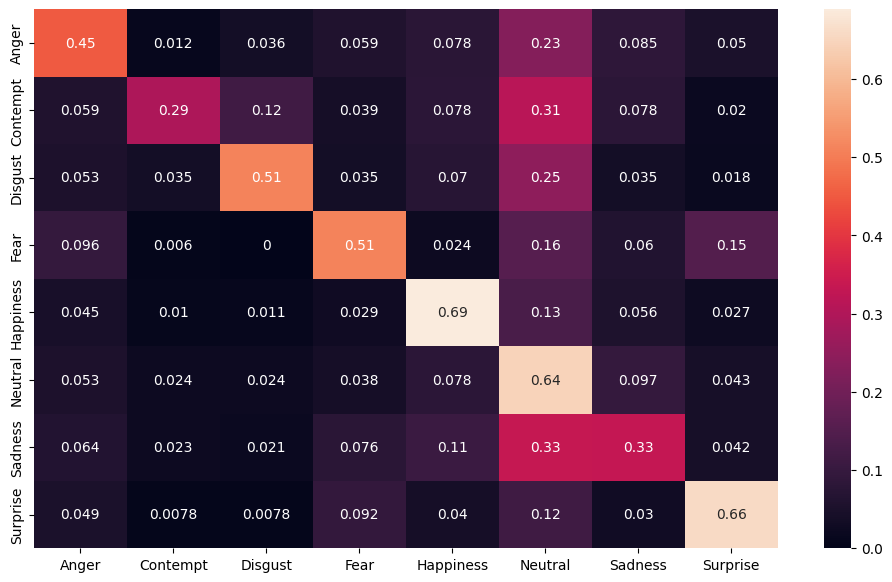

In [ ]:
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
print(precision_score(y_true, y_pred, average = "micro"))

0.5954359768981546


In [ ]:
print(precision_score(y_true, y_pred, average = "macro"))

0.4326862055572395


In [ ]:
print(recall_score(y_true, y_pred, average = "micro"))

0.5954359768981546


In [ ]:
print(recall_score(y_true, y_pred, average = "macro"))

0.5107289367419743
